# Similarity testing pipeline

-----

##### Imports

In [ ]:
from functools import partial

from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.utils.initialize import (
    generate_random_population_parallel,
)

from ariel_experiments.characterize.population import (
    # AnalyzedPopulation,
    get_full_analyzed_population,
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
    get_derived_population_properties
)

from ariel_experiments.characterize.population import (
    derive_matrix_numerics,
    matrix_derive_neighbourhood,
    get_full_analyzed_population,
    derive_numeric_summary
)
from ariel_experiments.gui_vis.gui import (
    IndividualVisualizer,
)
from ariel_experiments.gui_vis.gui_simple import (
    SimpleNavigator,
)

from ariel_experiments.gui_vis.visualize_tree import visualize_tree_from_graph

import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from ariel_experiments.gui_vis.view_mujoco import view

import matplotlib.pyplot as plt

##### constants/globals

In [ ]:
from rich.console import Console
console = Console()

In [ ]:
def plot_matrix_distribution(
    matrix: np.ndarray,
    triangle: str = "upper",
    include_diagonal: bool = False,
    cmap: str = "viridis",
    bins: int = 190,
    figsize: tuple[int, int] = (14, 6),
    title_prefix: str = ""
):
    """Plot matrix heatmap and value distribution side by side."""
    
    # Extract triangle values
    k_offset = 1 if not include_diagonal else 0
    
    if triangle.lower() == "upper":
        values = matrix[np.triu_indices_from(matrix, k=k_offset)]
        mask = np.tril(np.ones_like(matrix, dtype=bool), k=k_offset-1)
        triangle_name = "Upper"
    elif triangle.lower() == "lower":
        values = matrix[np.tril_indices_from(matrix, k=-k_offset)]
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=-k_offset+1)
        triangle_name = "Lower"
    else:
        raise ValueError("triangle must be 'upper' or 'lower'")
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        matrix,
        mask=mask,
        ax=axes[0],
        cmap=cmap,
        square=True,
        cbar_kws={'label': 'Value'}
    )
    diag_text = "with" if include_diagonal else "without"
    axes[0].set_title(f'{title_prefix}{triangle_name} Triangle Heatmap\n({diag_text} diagonal)')
    axes[1].hist(values, bins=bins, alpha=0.7, edgecolor='black', color='steelblue')
    axes[1].axvline(np.mean(values), color='black', linestyle='--', 
                    linewidth=1, label=f'Mean: {np.mean(values):.3f}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{title_prefix}Value Distribution (n={len(values)})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = (
        f'Min: {np.min(values):.3f}\n'
        f'Max: {np.max(values):.3f}\n'
        f'Std: {np.std(values):.3f}'
    )
    axes[1].text(0.98, 0.97, stats_text,
                transform=axes[1].transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    
    plt.tight_layout()
    return fig, axes


hyperparams

In [ ]:
population_size = 10
population = generate_random_population_parallel(population_size)

##### Compute

In [ ]:
radius_strategy = ctk.RadiusStrategy.TREE_GLOBAL
max_tree_radius = 3

missing_data_mode = ctk.MissingDataMode.SKIP_RADIUS

tanimoto_mode = ctk.TanimotoMode.COUNTS
weighting_mode = ctk.WeightingMode.LINEAR

softmax_beta = 1
power_mean_p = 1


similarity_config = ctk.SimilarityConfig(
    radius_strategy=radius_strategy,
    weighting_mode=weighting_mode,
    max_tree_radius=max_tree_radius,
    missing_data_mode=missing_data_mode,
    tanimoto_mode=tanimoto_mode,
    softmax_beta=softmax_beta,
    power_mean_p=power_mean_p,
)

In [ ]:
analyzed_population = get_full_analyzed_population(
    population,
    analyzers=[
        partial(analyze_neighbourhood, config=similarity_config),
    ],
    derivers=[],
    n_jobs=-1, # fastest
    hide_tracker=True
)
matrix_result = matrix_derive_neighbourhood(
    analyzed_population.raw,
    config=similarity_config,
    symmetric=True,
    n_jobs=-1,
    hide_tracker=False
)

analyzed_population.derived.update(matrix_result)

In [ ]:
analyzed_population.show_tree()

In [ ]:
matrix = analyzed_population.derived["similarity_matrix"]['full']
upper_triu_idx = np.triu_indices_from(matrix, k=1)
vals = matrix[upper_triu_idx]

-----

### Results

##### Quick overview

In [ ]:
fig, axes = plot_matrix_distribution(matrix)
plt.show()

##### Highest similarity-pairs

In [ ]:
N = 20
if vals.size == 0:
    top = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(-vals, k-1)[:k]               # top k (unsorted)
    sel = sel[np.argsort(-vals[sel])]                   # sorted desc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    top = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# top is a list of (row, col, value) tuples sorted by value desc
console.print(top)

iterator = 0

keep pressing this notebook cell to iterate over the robots

In [ ]:
node1 = ctk.from_graph(population[top[int(0 + iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[top[int(0 + iterator)][1]]).canonicalize()

console.print(f"viewing: {top[int(iterator)][0]} with similarity {[top[int(iterator)][2]]}")
view(node1.to_graph())
console.print(f"viewing: {top[int(iterator)][1]} with similarity {[top[int(iterator)][2]]}")
view(node2.to_graph())

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator = (iterator + 1) % N

##### Lowest similarity-pairs

In [ ]:
N = 20

if vals.size == 0:
    bottom = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(vals, k-1)[:k]                # bottom k (unsorted)
    sel = sel[np.argsort(vals[sel])]                    # sorted asc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    bottom = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# bottom is a list of (row, col, value) tuples sorted by value asc (lowest first)
console.print(bottom)
iterator = 0

In [ ]:
node1 = ctk.from_graph(population[bottom[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[bottom[int(iterator)][1]]).canonicalize()

console.print(f"viewing: {bottom[int(iterator)][0]} with similarity {[bottom[int(iterator)][2]]}")
view(node1.to_graph())
console.print(f"viewing: {bottom[int(iterator)][1]} with similarity {[bottom[int(iterator)][2]]}")
view(node2.to_graph())

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator = (iterator + 1) % N

-----

Fitness preperation

In [ ]:
fitness_array = (matrix.sum(axis=0) - 1) / len(population)
population_fitness = {'diversity_fitness' : fitness_array}
analyzed_population.raw.update(population_fitness)

deriver_list = [
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
]

new_derived = get_derived_population_properties(
    population_fitness,
    deriver_list,
    hide_tracker=True
)

matrix_stats = derive_matrix_numerics(
    analyzed_population.derived,
    key="similarity_matrix"
)

analyzed_population.derived.update(matrix_stats)
analyzed_population.derived.update(new_derived)

analyzed_population.show_tree()

##### Most similar Individuals

In [ ]:
tracker = 0

In [ ]:
max_dict = analyzed_population.derived['diversity_fitness']['max_first_idx']
max_idx = max_dict['idxs'][tracker]
max_value = max_dict['values'][tracker]

node_fittest = ctk.from_graph(population[max_idx]).canonicalize()
console.print(f"viewing {tracker + 1} / {len(population)} - individual {max_idx} - with value {max_value:2f}")

view(node_fittest.to_graph())
console.print(f"canonical string: {ctk.to_canonical_string(node_fittest)}", markup=False, highlight=False)
results = ctk.collect_neighbours_config_mode(node_fittest, config=similarity_config)
console.print(results)

tracker = (tracker + 1) % len(population)

##### Most Diverse individuals

In [ ]:
tracker = 0

In [ ]:
min_dict = analyzed_population.derived['diversity_fitness']['min_first_idx']
min_idx = min_dict['idxs'][tracker]
min_value = min_dict['values'][tracker]

node_weakest = ctk.from_graph(population[min_idx]).canonicalize()
console.print(f"viewing {tracker + 1} / {len(population)} - individual {min_idx} - with value {min_value:2f}")

view(node_weakest.to_graph())
console.print(f"canonical string: {ctk.to_canonical_string(node_weakest)}", markup=False, highlight=False)
results = ctk.collect_neighbours_config_mode(node_fittest, config=similarity_config)
console.print(results)

tracker = (tracker + 1) % len(population)

-----

##### Manual trial-and-error

import gecko

In [96]:
gecko = ctk.from_string("C[fb(H2H2B)l(HBHB[l(H1B)r(H3B)])]")

gecko_mut = ctk.from_string("C[fr(H1H1B)l(BBBHB[l(H1H)r(H3B2)])]")

In [97]:
console.print(ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config))

0.176

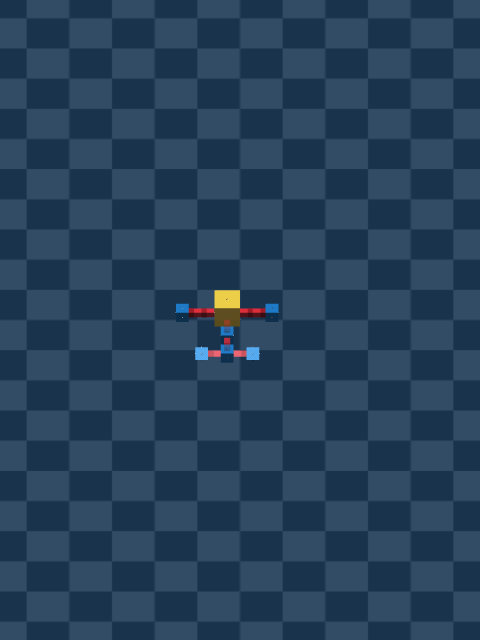

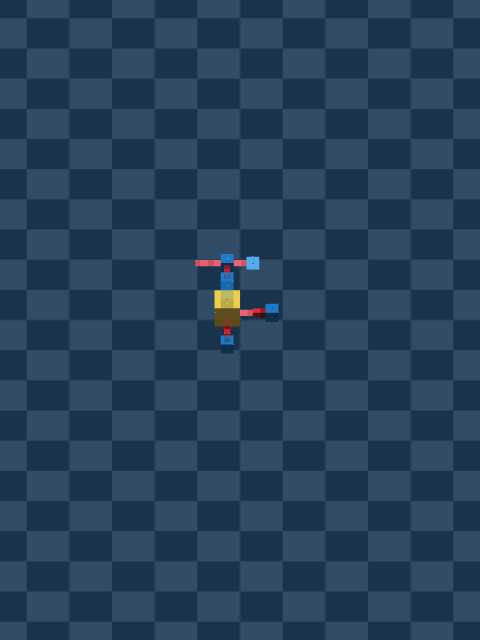

In [98]:
view(gecko.to_graph())
view(gecko_mut.canonicalize().to_graph())

apply random mutation

view and compare!

##### nx-TED distance baseline

In [89]:
import networkx as nx

In [90]:
gecko_graph = gecko.to_graph()
gecko_mut_graph = gecko_mut.to_graph()

very slow for deletions.....

In [91]:
nx.graph_edit_distance(gecko_graph, gecko_mut_graph, timeout=1)

4.0

inaccurate for rotations or faces

-----

### Misc

##### Interactive heatmap

In [92]:
fig = go.Figure(data=go.Heatmap(
    z=matrix,
    colorscale='Viridis',
    hovertemplate='Row: %{y}<br>Col: %{x}<br>Value: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Interactive Heatmap',
    xaxis_title='Column',
    yaxis_title='Row'
)
fig.show()


##### Gui for just data

In [93]:
simple_navigator = SimpleNavigator(analyzed_population.to_dict())

##### Visualize Robots

In [94]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population)

##### See graphs

In [95]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population, visualize_fn=visualize_tree_from_graph)